# 1 Preliminaries
## 1.1 Import
Import required libraries.

In [132]:
import csv
import pandas as pd
import numpy as np
from keras import callbacks, Model, layers, utils
import chess

## 1.2 Load Data
Load the pgn file and create DataFrame. It should have three columns:
- Color
- Board
- Move

In [148]:
row_val = {
    'a': 0,
    'b': 1,
    'c': 2,
    'd': 3,
    'e': 4,
    'f': 5,
    'g': 6,
    'h': 7,
}

def space_to_int(space):
    letter = chess.square_name(space) # returns letter of space (ex. a3)
    return 8-int(letter[1]), row_val[letter[0]] # returns row, column

def split_boards(board):
    """
    Splits board into 14 different boards
    :param board: current board
    :return: length 14 array of boards based on piece location and attack
    0-5 are white pieces (pawn, knight, bishop, rook, queen, king)
    6-11 is black pieces (pawn, knight, bishop, rook, queen, king)
    12 is white legal moves
    13 is black legal moves
    """
    res = np.zeros((14, 8, 8), dtype=np.int8) # creates array of length 14 where each element is a board
    
    for piece in chess.PIECE_TYPES:
        for square in board.pieces(piece, chess.WHITE):
            # gets the location of where the square is and stores it into res
            index = np.unravel_index(square, (8,8)) # see https://stackoverflow.com/questions/48135736/what-is-an-intuitive-explanation-of-np-unravel-index
            res[piece-1][7-index[0]][index[1]] = 1 # 7-index[0] is row, index[1] is column
        for square in board.pieces(piece, chess.BLACK):
            # same idea but black pieces this time
            index = np.unravel_index(square, (8,8))
            res[piece+5][7-index[0]][index[1]] = 1 # +5 because of res indexing
        
    turn = board.turn # store current turn to use later
    
    # get legal moves for white
    board.turn = chess.WHITE
    for move in board.legal_moves:
        r, c = space_to_int(move.to_square)
        res[12][r][c] = 1
        
    # get legal moves for black
    board.turn = chess.BLACK
    for move in board.legal_moves:
        r, c = space_to_int(move.to_square)
        res[13][r][c] = 1
        
    board.turn = turn # restore original turn
    
    return res

X_train = []
y_train = []                
with open('data/data.csv', mode ='r') as file:
    csvFile = csv.reader(file)
    next(csvFile) # skip headers
    for line in csvFile:
        board = chess.Board(line[0])
        X_train.append(split_boards(board))
        try:
            eval = int(line[1])
        except ValueError:
            eval = 10000 if line[1][1] == '+' else -10000
        y_train.append(eval/100)

X_train = np.asarray(X_train)
y_train = np.asarray(y_train)

print(X_train.shape)
print(y_train.shape)

(200000, 14, 8, 8)
(200000,)


# 2 Train Model
## 2.1 Create Model

In [142]:
depth = 2

# input layer
input = layers.Input(shape=(14,8,8))

# layers
x = layers.Conv2D(filters=32, kernel_size=3, padding='same', data_format='channels_last', activation='relu')(input)
for i in range(depth):
    previous = x
    x = layers.Conv2D(filters=32, kernel_size=3, padding='same', data_format='channels_last', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(filters=32, kernel_size=3, padding='same', data_format='channels_last', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Add()([x, previous])
    x = layers.Activation('relu')(x)
x = layers.Flatten()(x)
x = layers.Dense(1, activation='sigmoid')(x)

model = Model(inputs=input, outputs=x)

utils.plot_model(model, to_file='model.png', show_shapes=True)

model.summary()

You must install pydot (`pip install pydot`) for `plot_model` to work.


Model: "functional_21"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_21      │ (None, 14, 8, 8)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_63 (Conv2D)  │ (None, 14, 8, 32) │      2,336 │ input_layer_21[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_64 (Conv2D)  │ (None, 14, 8, 32) │      9,248 │ conv2d_63[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 14, 8, 32) │        128 │ conv2d_64[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 14, 8, 32) │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_65 (Conv2D)  │ (None, 14, 8, 32) │      9,248 │ activation_4[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 14, 8, 32) │        128 │ conv2d_65[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 14, 8, 32) │          0 │ batch_normalizat… │
│                     │                   │            │ conv2d_63[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_5        │ (None, 14, 8, 32) │          0 │ add_2[0][0]       │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_66 (Conv2D)  │ (None, 14, 8, 32) │      9,248 │ activation_5[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 14, 8, 32) │        128 │ conv2d_66[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_6        │ (None, 14, 8, 32) │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_67 (Conv2D)  │ (None, 14, 8, 32) │      9,248 │ activation_6[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 14, 8, 32) │        128 │ conv2d_67[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 14, 8, 32) │          0 │ batch_normalizat… │
│                     │                   │            │ activation_5[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_7        │ (None, 14, 8, 32) │          0 │ add_3[0][0]       │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_21          │ (None, 3584)      │          0 │ activation_7[0][… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_55 (Dense)    │ (None, 1)         │      3,585 │ flatten_21[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 43,425 (169.63 KB)

 Trainable params: 43,169 (168.63 KB)

 Non-trainable params: 256 (1.00 KB)

## 2.2 Fit Model

Epoch 1/1000
88/88 ━━━━━━━━━━━━━━━━━━━━ 38s 411ms/step - loss: 226.8974 - mean_absolute_error: 4.5189 - val_loss: 236.8562 - val_mean_absolute_error: 4.6004 - learning_rate: 0.0010
Epoch 2/1000
88/88 ━━━━━━━━━━━━━━━━━━━━ 36s 409ms/step - loss: 232.7712 - mean_absolute_error: 4.5713 - val_loss: 236.5345 - val_mean_absolute_error: 4.5655 - learning_rate: 0.0010
Epoch 3/1000
88/88 ━━━━━━━━━━━━━━━━━━━━ 37s 417ms/step - loss: 221.5642 - mean_absolute_error: 4.4399 - val_loss: 236.4108 - val_mean_absolute_error: 4.5482 - learning_rate: 0.0010
Epoch 4/1000
88/88 ━━━━━━━━━━━━━━━━━━━━ 38s 436ms/step - loss: 222.6653 - mean_absolute_error: 4.4394 - val_loss: 236.3357 - val_mean_absolute_error: 4.5394 - learning_rate: 0.0010
Epoch 5/1000
88/88 ━━━━━━━━━━━━━━━━━━━━ 38s 429ms/step - loss: 219.5978 - mean_absolute_error: 4.4005 - val_loss: 236.2679 - val_mean_absolute_error: 4.5307 - learning_rate: 0.0010
Epoch 6/1000
88/88 ━━━━━━━━━━━━━━━━━━━━ 39s 443ms/step - loss: 223.5116 - mean_absolute_error: 

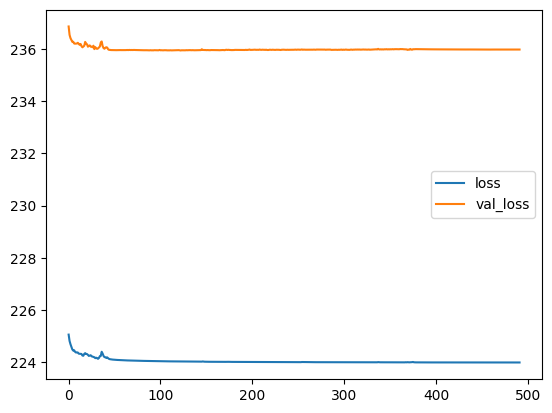

In [150]:
early_stopping = callbacks.EarlyStopping(
    monitor='loss',
    min_delta=0.0001,  # minimium amount of change to count as an improvement
    patience=20,  # how many epochs to wait before stopping
    restore_best_weights=True,
)

# compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    batch_size=2048,
    epochs=1000,
    callbacks=[
        callbacks.ReduceLROnPlateau(monitor='loss', patience=10),
        early_stopping,
    ],
    verbose=1,
)

history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()

model.save('ai.keras')